# G@C Recycling Volume vs Number of Collection Point

Model Summary:
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3783.7636   2233.307      1.694      0.134   -1497.168    9064.695
G@C_collection_points    67.9223      9.753      6.964      0.000      44.861      90.984

R-squared: 0.8739


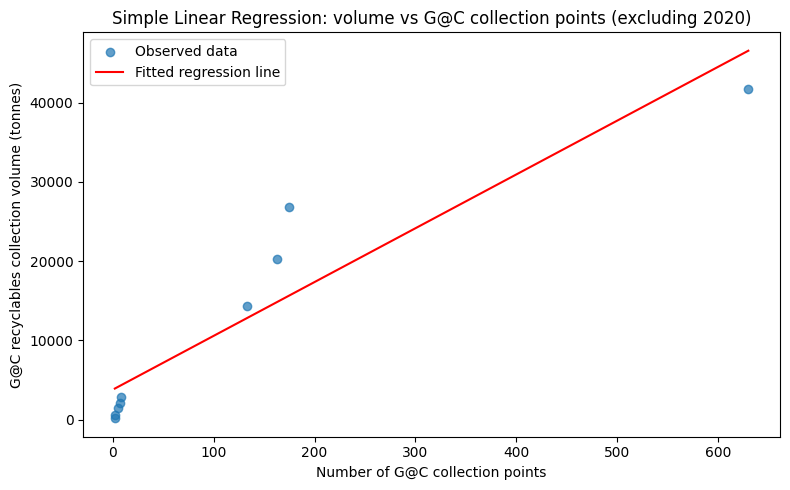

In [2]:
# !pip install pandas numpy matplotlib scikit-learn statsmodels openpyxl
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the dataset (HK MSW Volume and Recycling Rat sheet is the default first sheet)
df = pd.read_excel("../General Stats_G@C_clean.xlsx")


# ---------- Simple Linear Regression: volume vs G@C collection points (excluding 2020) ----------

# Column names (follow the cleaned-data headers)
col_year = "Year"
col_pts  = "Number of G@C collection points"
col_vol  = "G@C recyclables collection volume (tonnes)"

# Raw series
pts_raw  = df[col_pts]
vol_raw  = df[col_vol]
years    = df[col_year] if col_year in df.columns else pd.Series(np.nan, index=df.index)

# Keep rows where both variables are present
mask = pts_raw.notna() & vol_raw.notna()

# Exclude 2020 data (as requested)
if years.notna().any():
    mask &= (years != 2020)

# Convert to numeric
X_series = pd.to_numeric(pts_raw[mask], errors="coerce")  # number of collection points
y_series = pd.to_numeric(
    vol_raw[mask].astype(str).str.replace(",", ""),        # e.g. "26,900.0" → 26900.0
    errors="coerce"
)

# Drop any remaining NaNs
valid = X_series.notna() & y_series.notna()
X_gc   = X_series.loc[valid].to_frame(name="G@C_collection_points")
y_vol  = y_series.loc[valid]

# Fit model using sklearn for predictions
lin_reg_gc = LinearRegression()
lin_reg_gc.fit(X_gc, y_vol)

# Fit model using statsmodels for statistical tests
X_gc_sm   = sm.add_constant(X_gc)  # Add constant term for intercept
model_gc  = sm.OLS(y_vol, X_gc_sm)
results_gc = model_gc.fit()

# Predictions for plotting
y_pred_gc = lin_reg_gc.predict(X_gc)

print("Model Summary:")
print(results_gc.summary().tables[1])  # Print coefficient statistics
print(f"\nR-squared: {results_gc.rsquared:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_gc, y_vol, alpha=0.7, label="Observed data")
plt.plot(X_gc, y_pred_gc, color="red", label="Fitted regression line")
plt.xlabel("Number of G@C collection points")
plt.ylabel("G@C recyclables collection volume (tonnes)")
plt.title("Simple Linear Regression: volume vs G@C collection points (excluding 2020)")
plt.legend()
plt.tight_layout()
plt.show()


**Collection-points coefficient ($\hat \beta_1$) ≈ 67.92 (p ≈ 0.0002 < 0.05)**  

- There is a **statistically significant positive association** between the number of G@C collection points and the G@C recyclables collection volume: years with more collection points tend to have much higher G@C recycling throughput, even after excluding 2020.  

- The number of G@C collection points alone explains a **large proportion of the variation** in recycling volume (about **87% of the variance**, based on R-squared approx 0.87), suggesting that network expansion is strongly linked to increases in recyclables collected by G@C.
